In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad, solve_ivp

G = 6.6743*10**(-11) #m^3/kg/s^2
g = 9.81 #m/s^2
Mearth = 5.972*10**24 #kg
Mmoon = 7.35*10**22 #kg
Rearth = 6378.1*10**3 #m
Rmoon = 1738.1*10**3#m
RotE = 7.272*10**(-5) #rad/s


### Part 1: The Ideal Case

1.1 The time it takes for the object to hit the bottom of the shaft is 28.574165529004855 seconds
1.4 The fall time analytically is [28.57416553] seconds. This is approximately equal to the solution found using the freefall equations


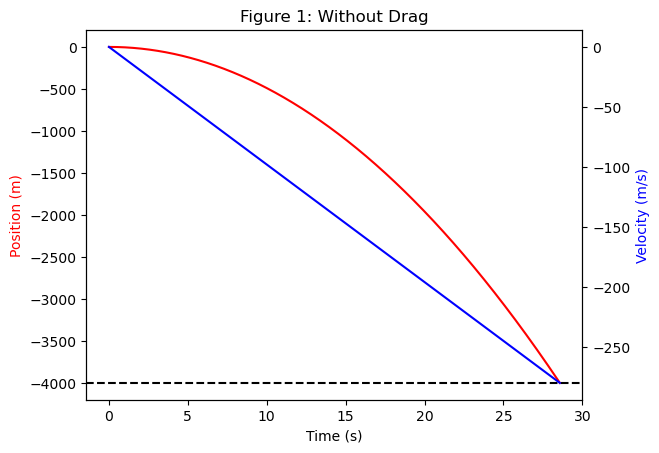

In [2]:
#Part 1: The Ideal Case

#1: W/out drag

def freefall(dx, M, v0, R):
    ag = (G*M)/(R**2)
    coefficients = [0.5*ag, v0, -dx]
    return np.roots(coefficients)

falltime = freefall(4*10**3, Mearth, 0, Rearth)[0] #using the first root, as the 2nd is extraneous. 
print(f"1.1 The time it takes for the object to hit the bottom of the shaft is {falltime} seconds")

#2: def coupled eq

#s is state vector; for this one it is of size 2. 
def wdrag(t, s):
    y = s[0]
    v = s[1]
    dydt = v
    dvdt = -G*Mearth/(Rearth**2) - alpha*(v**gamma)
    return np.concatenate(([dydt],[dvdt]))


#3: Solving

#set alpha and gamma to global variables (but made sure that they were correctly assigned for future calcs)
alpha = 0
gamma = 2
t0,tf,n = 0, falltime, 1000
teval = np.linspace(t0,tf,n)
ics = [0,0]


soln = solve_ivp(fun = wdrag, t_span = (t0,tf), y0 = ics, t_eval = teval)
t = soln.t
y = soln.y[0]
v = soln.y[1]

fig1, ax1 = plt.subplots()
ax11 = ax1.twinx()
ax1.plot(t,y, '-r', label = 'Position (m)')
ax11.plot(t,v, '-b', label = 'Velocity (m/s)')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Position (m)', color = 'red')
ax11.set_ylabel('Velocity (m/s)', color = 'blue')
ax1.axhline(y = -4000, color = 'black', linestyle = 'dashed')
ax1.set_title("Figure 1: Without Drag")
fig1.savefig("Figure1")

#4: Events
def stop(t, ics):
    y = ics[0]
    v = ics[1]
    return 4000- abs(y) #y is negative, so subtracting it would make it positive

t0,tf1,n = 0, 32, 1000
teval1 = np.linspace(t0,tf,n)

soln1 = solve_ivp(fun = wdrag, t_span = (t0,tf1), y0 = ics, t_eval = teval1, events = stop)
falltimeanalytic = soln1.t_events[0]
print(f"1.4 The fall time analytically is {falltimeanalytic} seconds. This is approximately equal to the solution found using the freefall equations")

### Part 2: Including Drag and a Variable g

The fall time with a varying gravitational acceleration is [28.57565909] seconds, while with a constant acceleration it is 28.574165529004855 seconds. As we can see, varying the gravitational acceleration results in a fall time that is [-5.22695226e-05] percent larger. This is because the position y and the gravitational acceleration are inversely proportional, meaning over time the velocity, and therefore position will be smaller.


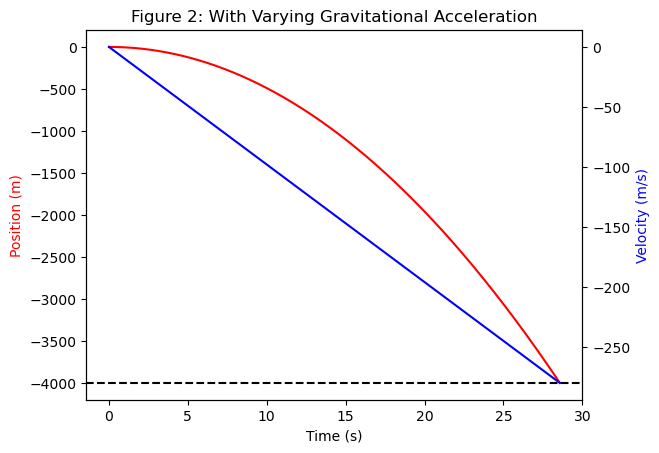

In [3]:
#Part 2: Including Drag and A Variable g

#1: g(r) and replotting
alpha = 0
def g(r):
    g0 = G*Mearth/(Rearth**2)
    return g0*((Rearth-abs(r))/Rearth) #again, y is negative- also we are measuring from the center of the earth so cannot just use y.

def varyg(t, s):
    y = s[0]
    v = s[1]
    dydt = v
    dvdt = -g(y) + alpha*(np.abs(v)**gamma) #sign of drag changed to positive, since g is negative and drag opposes
    return np.concatenate(([dydt],[dvdt]))

soln2 = solve_ivp(fun = varyg, t_span = (t0,tf), y0 = ics, t_eval = teval)
t2 = soln2.t
y2 = soln2.y[0]
v2 = soln2.y[1]

fig2, ax2 = plt.subplots()
ax21 = ax2.twinx()
ax2.plot(t2,y2, '-r')
ax21.plot(t2,v2, '-b')
ax2.axhline(y = -4000, linestyle = 'dashed', color = 'black')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Position (m)', color = 'red')
ax21.set_ylabel('Velocity (m/s)', color = 'blue')
ax2.set_title('Figure 2: With Varying Gravitational Acceleration')
fig2.savefig("Figure2")

#2: Fall time

soln3 = solve_ivp(fun = varyg, t_span = (t0,tf1), y0 = ics, t_eval = teval1, events = stop)
falltime3 = soln3.t_events[0]
print(f"The fall time with a varying gravitational acceleration is {falltime3} seconds, while with a constant acceleration it is {falltime} seconds. As we can see, varying the gravitational acceleration results in a fall time that is {(falltime-falltime3)/falltime} percent larger. This is because the position y and the gravitational acceleration are inversely proportional, meaning over time the velocity, and therefore position will be smaller.")



To find the correct drag value, we will run a for loop over many alphas, and plot alpha against the maximum velocity
On the plot, we can see that the eighth point seems to be the correct alpha, resulting in a terminal velocity of ~50m/s. This would be an alpha of 0.00415. We will round this to 0.004.
The fall time, including drag, is [84.32902983] seconds.


Text(0.5, 1.0, 'Position and Velocity with Drag')

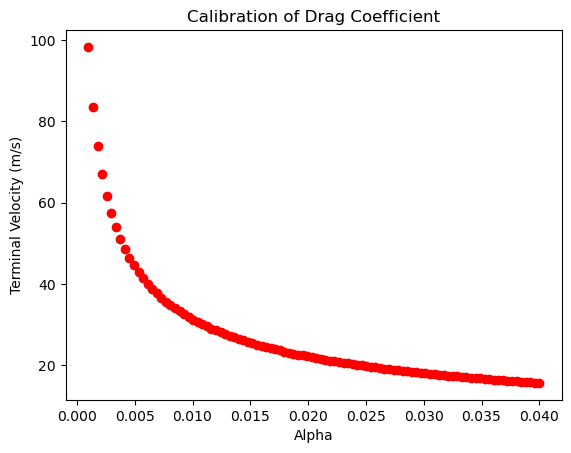

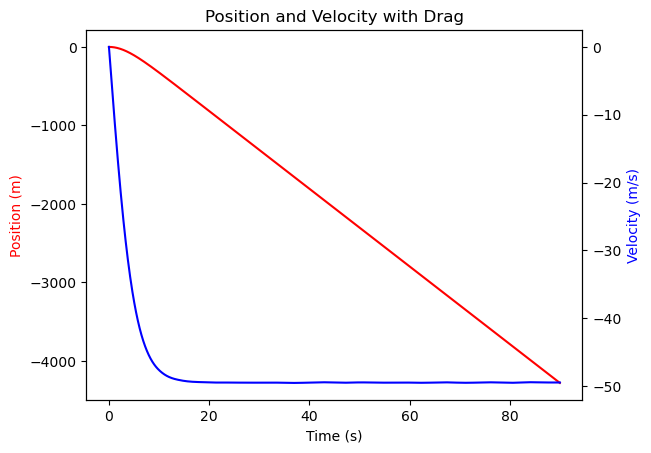

In [4]:
#3: Calibrating Drag
print(f"To find the correct drag value, we will run a for loop over many alphas, and plot alpha against the maximum velocity")

fig3, ax3 = plt.subplots()
ax3.set_xlabel('Alpha')
ax3.set_ylabel('Terminal Velocity (m/s)')
ax3.set_title('Calibration of Drag Coefficient')
alphas = np.linspace(0.001,0.04,100) #adjusted the scope of this to hone in on the correct alpha
for i in alphas:
    alpha = i
    soln5 = solve_ivp(fun = varyg, t_span = (t0,tf), y0 = ics, t_eval = teval)
    v5 = soln5.y[1]
    term = np.abs(v5).max()
    ax3.plot(i, term, 'or')
print(f"On the plot, we can see that the eighth point seems to be the correct alpha, resulting in a terminal velocity of ~50m/s. This would be an alpha of {alphas[8]:.5f}. We will round this to 0.004.")
alpha = 0.004

t04, tf4, n4 = 0, 90, 1000
teval4 = np.linspace(t04,tf4,n4)
soln4 = solve_ivp(fun = varyg, t_span = (t04,tf4), y0 = ics, t_eval = teval4, events = stop)
falltime4 = soln4.t_events[0]
t4 = soln4.t
y4 = soln4.y[0]
v4 = soln4.y[1]
print(f"The fall time, including drag, is {falltime4} seconds.")
fig4,ax4 = plt.subplots()
ax41 = ax4.twinx()
ax4.plot(t4,y4, '-r')
ax41.plot(t4,v4,'-b')
ax4.set_xlabel('Time (s)')
ax4.set_ylabel('Position (m)', color = 'red')
ax41.set_ylabel('Velocity (m/s)', color = 'blue')
ax4.set_title('Position and Velocity with Drag')

### Part 3: The Coriolis Force

The time at which the test mass hits the shaft is [21.9159497] seconds, and at -2352.915860087584 meters.
Since we drop the mass from the center, it only needs to move ~2.5m in any direction in order to hit the wall. We can see on the graph that the transverse position exceeds that threshold at ~2500m down. Therefore, the test mass will hit the wall before it hits the bottom of the shaft.
The time at which the test mass hits the shaft is [29.68919136] seconds, and at -1296.1248248851095 meters.
We can see that turning on drag triples the fall time, and increases the transverse travel by 500%. With drag, the test mass hits the wall somewhere between 1000 and 2000 meters.


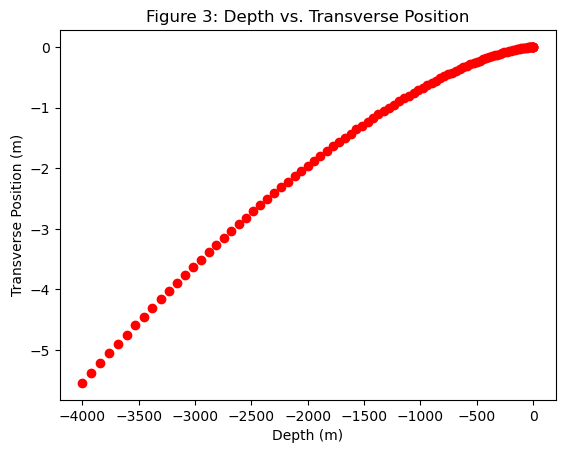

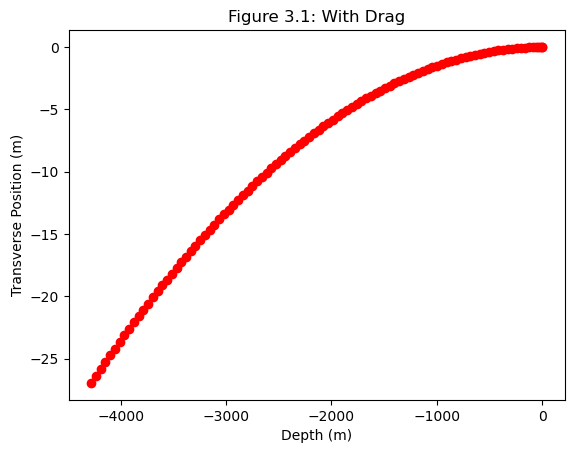

In [5]:
#Part 3: The Coriolis Force

#1: Defining the force
def wcoriolis(t, s):
    r = s[0:3] #changed s to be a vector of length 6 - three position arguments, 3 velocity.
    v = s[3:6]
    drdt = v
    dvydt = [-g(r[1]) + alpha*(np.abs(v[1])**gamma) - 2*RotE*v[0]] #includes g, drag, and coriolis
    dvxdt = [2*RotE*v[1]] #just coriolis
    dvzdt = [0] #nothing
    return np.concatenate((drdt, dvxdt, dvydt, dvzdt))

alpha = 0 #Set back to 0 since it's global.

#2: plotting

#tspan 
t06, tf6, n6 = 0,falltime,100
teval6 = np.linspace(t06, tf6, n6)

#initial conditions:
ics6 = [0,0,0,0,0,0]

#hitting the wall
def hit(t,s):
    return 2.5-abs(s[0])
    
soln6 = solve_ivp(fun = wcoriolis, t_span = (t06,tf6), y0 = ics6, t_eval = teval6, events = hit)
ry = soln6.y[1]
rx = soln6.y[0]
hittime = soln6.t_events[0]
hitpos = soln6.y_events[0][0][1]
print(f"The time at which the test mass hits the shaft is {hittime} seconds, and at {hitpos} meters.")

fig6, ax6 = plt.subplots()
ax6.plot(ry,rx, 'or')
ax6.set_xlabel('Depth (m)')
ax6.set_ylabel('Transverse Position (m)')
ax6.set_title('Figure 3: Depth vs. Transverse Position')
fig6.savefig('Figure 3')

#3: evaluation
print("Since we drop the mass from the center, it only needs to move ~2.5m in any direction in order to hit the wall. We can see on the graph that the transverse position exceeds that threshold at ~2500m down. Therefore, the test mass will hit the wall before it hits the bottom of the shaft.")

#4: w/drag
alpha = 0.004

t07, tf7, n7 = 0, 90, 100
teval7 = np.linspace(t07,tf7,n7)

soln7 = solve_ivp(fun = wcoriolis, t_span = (t07,tf7), y0 = ics6, t_eval = teval7, events = hit)
ry7 = soln7.y[1]
rx7 = soln7.y[0]
hittime1 = soln7.t_events[0]
hitpos1 = soln7.y_events[0][0][1]
print(f"The time at which the test mass hits the shaft is {hittime1} seconds, and at {hitpos1} meters.")

fig7, ax7 = plt.subplots()
ax7.plot(ry7,rx7, 'or')
ax7.set_xlabel('Depth (m)')
ax7.set_ylabel('Transverse Position (m)')
ax7.set_title('Figure 3.1: With Drag')

print('We can see that turning on drag triples the fall time, and increases the transverse travel by 500%. With drag, the test mass hits the wall somewhere between 1000 and 2000 meters.')

### Part 4: An Infinitely Long Tunnel

We see that the test mass is able to fall through the entirety of the earth. At the time when the object passes the center of the earth, at -6378100.0 meters, we see that the velocity has a critical point, and meaning the acceleration is 0. After this, we see that the velocity begins increasing again. We see the position graph has an inflection point there, and a critical point when it hits -12756200.0 meters. At this time, the velocity returns to 0. We can see from this graph that both the position and velocity will be periodic.
It will take 1267.228 seconds for the test mass to reach the center of the earth. At this time, the velocity is -7905.676 m/s.
Since the motion is periodic, the time to the other side of the Earth would be 2 times the time to the center. This would be 2534.456457746172 seconds.
The orbital period for an object orbiting at the earth's surface would be 5069.371 seconds. This is approximately double the time we found for the object to fall through the entire eart

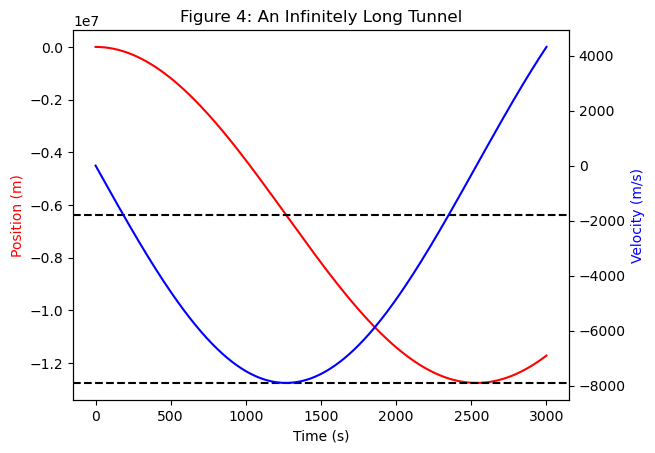

In [15]:
#Part 4: An Infinitely Long Tunnel

#Since we are neglecting the coriolis force, we will use the previously defined "varyg" function. 
alpha = 0

#tspan 
t08,tf8,n8 = 0,3000,1000
teval8 = np.linspace(t08,tf8,n8)

#ics
ics8 = [0,0]

soln8 = solve_ivp(fun = varyg, t_span = (t08, tf8), y0 = ics8, t_eval = teval8)
t8 = soln8.t
y8 = soln8.y[0]
v8 = soln8.y[1]

fig8, ax8 = plt.subplots()
ax81 = ax8.twinx()
ax8.plot(t8,y8, '-r')
ax81.plot(t8,v8,'-b')
ax8.axhline(-Rearth, linestyle = 'dashed', color = 'black')
ax8.axhline(-2*Rearth, linestyle = 'dashed', color = 'black')
ax8.set_xlabel('Time (s)')
ax8.set_ylabel('Position (m)', color = 'red')
ax81.set_ylabel('Velocity (m/s)', color = 'blue')
ax8.set_title('Figure 4: An Infinitely Long Tunnel')
fig8.savefig('Figure4')
print(f"We see that the test mass is able to fall through the entirety of the earth. At the time when the object passes the center of the earth, at -{Rearth} meters, we see that the velocity has a critical point, and meaning the acceleration is 0. After this, we see that the velocity begins increasing again. We see the position graph has an inflection point there, and a critical point when it hits -{2*Rearth} meters. At this time, the velocity returns to 0. We can see from this graph that both the position and velocity will be periodic.")

#2: Events
def center(t, s):
    return Rearth - np.abs(s[0])

soln81 = solve_ivp(fun = varyg, t_span = (t08, tf8), y0 = ics8, t_eval = teval8, events = center)
ttocenter1 = soln81.t_events[0][0]
vatcenter1 = soln81.y_events[0][0][1]
print(f"It will take {ttocenter1:.3f} seconds for the test mass to reach the center of the earth. At this time, the velocity is {vatcenter1:.3f} m/s.")
print(f"Since the motion is periodic, the time to the other side of the Earth would be 2 times the time to the center. This would be {2*ttocenter1} seconds.")

#3: Vs orbital period at R = Rearth

vorbit = np.sqrt(G*Mearth/(Rearth))
periodor= (2*np.pi*Rearth)/vorbit
print(f"The orbital period for an object orbiting at the earth's surface would be {periodor:.3f} seconds. This is approximately double the time we found for the object to fall through the entire earth.")
testT = (2*np.pi*(Rearth**(1.5)))/((G*Mearth)**(0.5))


### Part 5: A Non-Uniform Earth

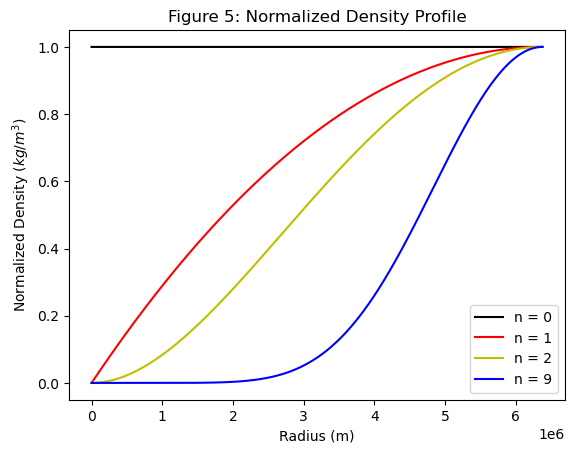

In [7]:
#Part 5: A non-uniform Earth

#1: Normalized Density Profile
def roe(r, rn, n):
    return rn*(1-((Rearth - abs(r))**2)/(Rearth**2))**n

n9 = 10000
radius = np.linspace(0, Rearth, n9)
fig9, ax9 = plt.subplots()
ax9.plot(radius, roe(radius, 1, 0), color = 'black', label = 'n = 0')
ax9.plot(radius, roe(radius, 1, 1), '-r', label = 'n = 1')
ax9.plot(radius, roe(radius, 1, 2), '-y', label = 'n = 2')
ax9.plot(radius, roe(radius, 1, 9), '-b', label = 'n = 9')
ax9.legend()
ax9.set_xlabel('Radius (m)')
ax9.set_ylabel('Normalized Density ($kg/m^3$)')
ax9.set_title('Figure 5: Normalized Density Profile')
fig9.savefig('Figure 5')

#Calibrating roe naught: 

#Defining the integrand w/o roe naught, since we can pull it out and solve for it
def integrand2(r, n):
    return (r**2)*(1-(r**2)/(Rearth**2))**n

#Defined a function where we divide the mass by the volume estimation to solve for roe naught
def solvern(n): #since the only changing variable here is n, opted to remove r
    result = 4*np.pi*quad(integrand2, 0, Rearth, args = (n))[0]
    return (1/result)*Mearth #we can see that this will give density as for the n = 0 case, it is exactly the mass of the earth divided by the volume of a sphere

ns = [0,1,2,9]
rns = [solvern(0), solvern(1), solvern(2), solvern(9)]
    


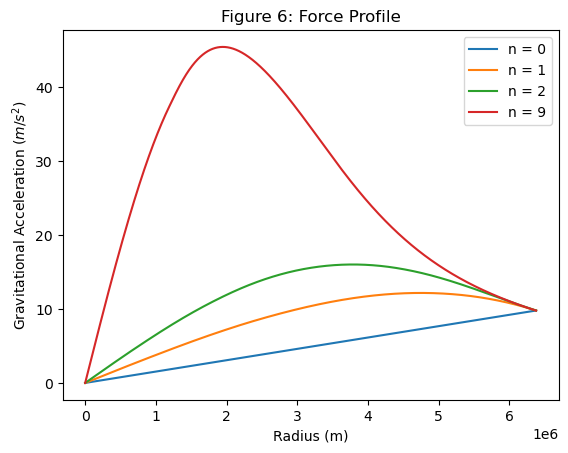

In [8]:
#The first version of the code used quad; however, I could not use that function later on when trying to plot the 
# gravitational acceleration over radius. I chose to use solve_ivp instead, and replaced the 
# To get final estimation, use soln = solve_ivp of the function, then take soln.y[0][-1]

def mass(r, s, rn, n):
    dmdr = 4*np.pi*(r**2)*rn*((1-(r**2)/(Rearth**2))**n)
    return [dmdr]

#Defined function of gravity over different densities. deng[0] is the radii measured over, deng[1] is the gravity
# at said radii

def deng(r, rn, n):
    reval = np.linspace(1,r,10000)
    m = solve_ivp(fun = mass, t_span = (1,r), y0 = [0], t_eval = reval, args = (rn, n))
    radius1 = m.t
    mass1 = m.y[0]
    grav = G*mass1/(radius1**2)
    return np.stack((radius1, grav))

#2: Force Profile:
fig10, ax10 = plt.subplots()

#used for loop to go through all values of n easily
for i in range(len(ns)):
    temp = deng(Rearth, rns[i], ns[i])
    ri = temp[0]
    gi = temp[1]
    ax10.plot(ri,gi, label = f"n = {ns[i]}")

ax10.legend()
ax10.set_xlabel('Radius (m)')
ax10.set_ylabel('Gravitational Acceleration ($m/s^2$)')
ax10.set_title('Figure 6: Force Profile')
fig10.savefig('Figure 6')

For n = 0, the time to the center is 1267.228 seconds, and the velocity at that time is 7905.676 m/s.
For n = 1, the time to the center is 1096.509 seconds, and the velocity at that time is 10462.057 m/s.
For n = 2, the time to the center is 1035.162 seconds, and the velocity at that time is 12202.087 m/s.
For n = 9, the time to the center is 944.179 seconds, and the velocity at that time is 18392.475 m/s.
[5494.867409551199, 13737.168523877996, 24040.044916786497, 135545.12141863423]


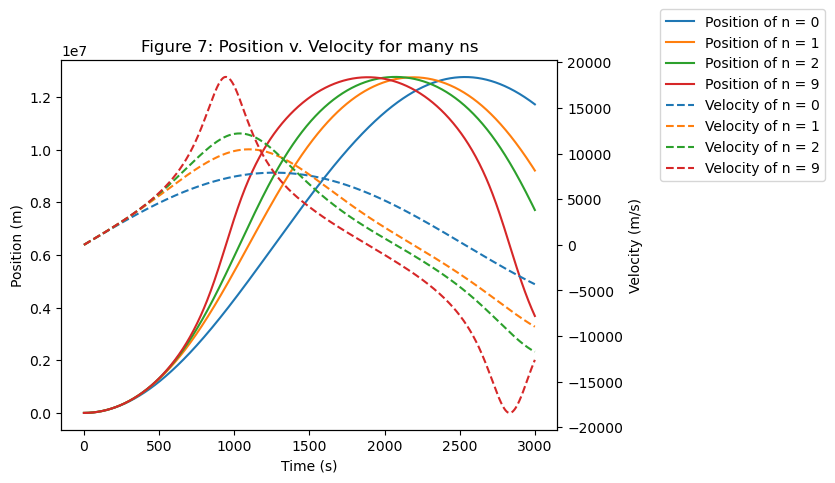

In [9]:
#3: Position and Velocity

#Define a new function using deng as the gravitational acceleration
def varyden(t, s, rn, n):
    y = s[0]
    v = s[1]
    r = Rearth - y 
    g = deng(r,rn,n)[1][-1]
    dydt = v
    dvdt = g + alpha*(np.abs(v)**gamma)
    return np.concatenate(([dydt], [dvdt]))

#tspan
t09, tf9, n9 = 0, 3000, 1000
teval9 = np.linspace(t09,tf9,n9)

#ics 
ics9 = [0,0]


soln9 = solve_ivp(fun = varyden, t_span = (t09,tf9), y0 = ics9, t_eval = teval9, args = (rns[0], ns[0]))
t9 = soln9.t
y9 = soln9.y[0]
v9 = soln9.y[1]

fig11, ax11 = plt.subplots()
ax111 = ax11.twinx()

#for part 6 question 3: 
#wanted to compare the different densities for the various ns to the moon, so put these in before to collect
# the data. 
tstoc = []
density = []

def center2(t,s,rn,n): #had to define another stopping funct b/c center did not have the same number of variables
    return Rearth-s[0]

for i in range(len(ns)):
    solni = solve_ivp(fun = varyden, t_span = (t09,tf9), y0 = ics9, 
                      t_eval = teval9, args = (rns[i], ns[i]), events = center2)
    ti = solni.t
    yi = solni.y[0]
    vi = solni.y[1]
    ttocenter = solni.t_events[0][0]
    vatcenter = solni.y_events[0][0][1]
    print(f"For n = {ns[i]}, the time to the center is {ttocenter:.3f} seconds, and the velocity at that time is {vatcenter:.3f} m/s.")
    density.append(rns[i])
    tstoc.append(ttocenter)
    ax11.plot(ti,yi, label = f"Position of n = {ns[i]}")
    ax111.plot(ti,vi, linestyle = 'dashed', label = f"Velocity of n = {ns[i]}")

fig11.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax11.set_xlabel('Time (s)')
ax11.set_ylabel('Position (m)')
ax111.set_ylabel('Velocity (m/s)')
ax11.set_title('Figure 7: Position v. Velocity for many ns')
fig11.savefig('Figure 7')
print(rns)

### Part 6: A Lunar Mine Shaft: 

The time to the center of the moon is 1624.928 seconds, and the velocity at that time is -1679.982 m/s.
The density of the moon is 3341.754, while the constant density of the earth is 5494.867409551199
The orbital velocity for the moon is: 1679.999, and the period is 6500.480746965868 seconds


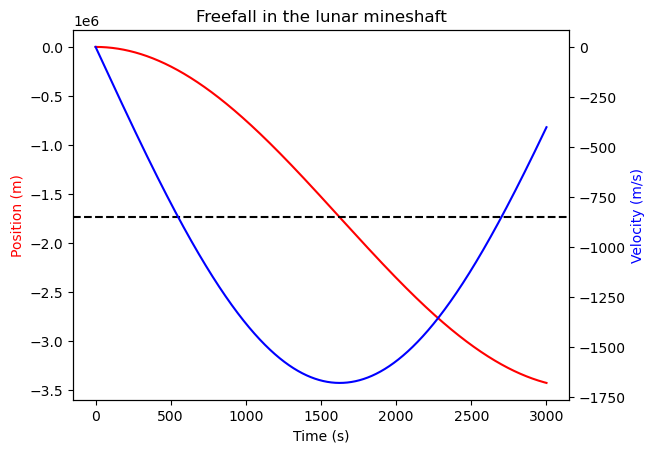

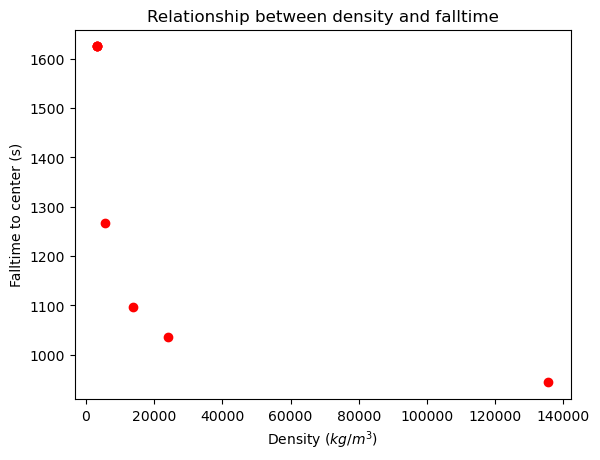

In [18]:
#Part 6: A Lunar Mine Shaft: 

def gmoon(r): #redefined the functions for the moon, since I specified the earlier ones for the earth's gravity.
    g0 = G*Mmoon/(Rmoon**2)
    return g0*((Rmoon-abs(r))/Rmoon)

def moon(t, s): 
    y = s[0]
    v = s[1]
    dydt = v
    dvdt = -gmoon(y) + alpha*(np.abs(v)**gamma)
    return np.concatenate(([dydt], [dvdt]))

def centerm(t,s):
    return Rmoon - abs(s[0])

t0m, tfm, nm = 0, 3000, 5000
tevalm = np.linspace(t0m,tfm,nm)

solnm = solve_ivp(fun = moon, t_span = (t0m, tfm), y0 = ics9, t_eval = tevalm, events = centerm)
tm = solnm.t
ym = solnm.y[0]
vm = solnm.y[1]

ttocm = solnm.t_events[0][0]
vatcm = solnm.y_events[0][0][1]

figm, axm = plt.subplots()
axm1 = axm.twinx()
axm.plot(tm, ym, '-r')
axm1.plot(tm, vm, '-b')
axm.axhline(-Rmoon, linestyle = 'dashed', color = 'black')
axm.set_xlabel('Time (s)')
axm.set_ylabel('Position (m)', color = 'red')
axm1.set_ylabel("Velocity (m/s)", color = 'blue')
axm.set_title("Freefall in the lunar mineshaft")

print(f"The time to the center of the moon is {ttocm:.3f} seconds, and the velocity at that time is {vatcm:.3f} m/s.")

roemoon = Mmoon/((4*np.pi/3)*(Rmoon**3))
print(f"The density of the moon is {roemoon:.3f}, while the constant density of the earth is {rns[0]}")
density.append(roemoon)
tstoc.append(ttocm)


fig12, ax12 = plt.subplots()
ax12.plot(density, tstoc, 'or')
ax12.set_xlabel("Density ($kg/m^3$)")
ax12.set_ylabel("Falltime to center (s)")
ax12.set_title("Relationship between density and falltime")

vorbitm = np.sqrt((G*Mmoon)/(Rmoon))
torbitm = (2*np.pi*Rmoon)/vorbitm

print(f"The orbital velocity for the moon is: {vorbitm:.3f}, and the period is {torbitm} seconds")